In [310]:
import sys

import matplotlib.pyplot as plt
import multiprocessing as mp
import anndata as ad
import pandas as pd
import scanpy as sc
import argparse
import scipy.stats as stats

import json
import numpy as np
import pickle
import sys
import os
import seaborn as sns
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
# Load imports from git directory
import pairwise_functions as pf
import gc

In [198]:
import seaborn as sns

def plot_heatmap(passing_cells_df, title = "", min_col_n=10, min_row_n=10, row_clust = "cell_type_prediction", columns_clust = None, scale_by_col = True, min_value_for_label=5, sort_alpha_numerically=False, show_vert_lines=False, show_horizontal_lines=False, is_wide = False):

# create heatmap of variable "cluster_alias" and "cell_type_prediction"
    if not is_wide:
        passing_cells_df = passing_cells_df[[row_clust, columns_clust]]
        pivot_df = passing_cells_df.pivot_table(index=row_clust, columns=columns_clust, aggfunc=len, fill_value=0)
    else:
        pivot_df = passing_cells_df

    # if column has less than n cells, remove it
    pivot_df = pivot_df.loc[:, pivot_df.sum(axis=0) > min_col_n]
    # if row has less than n cells, remove it
    pivot_df = pivot_df.loc[pivot_df.sum(axis=1) > min_row_n, :]

    pivot_df.sort_index(inplace=True, axis=1, ascending=True)

    # if scaling by columns 
    if not sort_alpha_numerically:
        if scale_by_col:
            max_index = pivot_df.idxmax(axis=0)
            max_index = max_index.sort_values()
            pivot_df = pivot_df[max_index.index]
        else:
            max_index = pivot_df.idxmax(axis=1)
            max_index = max_index.sort_values()
            pivot_df = pivot_df.loc[max_index.index]
    else:
        #sort pivot_df index in place
        pivot_df.sort_index(inplace=True, axis=0, ascending=False)
    annot_mask = np.where(pivot_df > min_value_for_label, pivot_df.astype(str), "")


    # scale by column
    if scale_by_col:
        pivot_df = pivot_df.div(pivot_df.sum(axis=0), axis=1)
    else:
        pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)

    plt.figure(figsize=(30, 20))
    sns.heatmap(pivot_df, cmap="viridis", xticklabels=True, yticklabels=True, cbar=True)
    # sns.heatmap(pivot_df, cmap="viridis", cbar=False)
    # rotate x axis labels 45 degrees
    plt.title(title)
    x_tick_options = {"fontsize": "large"}
    plt.xticks(ha="center", **x_tick_options)
    y_ticks_options = {"fontsize": "large"}
    plt.yticks(**y_ticks_options)

    # Add vertical lines to show separation between ticks
    if show_vert_lines:
        alternating_colors = ["white",  "orange", "yellow", "pink"]
        n_colors = len(alternating_colors)
        for i in range(len(pivot_df.columns)):
            current_color = alternating_colors[i % n_colors]
            plt.axvline(i, color=current_color, linewidth=0.5)

    if show_horizontal_lines:
        alternating_colors = ["white",  "orange", "yellow", "pink"]
        n_colors = len(alternating_colors)
        for i in range(len(pivot_df.index)):
            current_color = alternating_colors[i % n_colors]
            plt.axhline(i, color=current_color, linewidth=0.5)

    plt.show()
    return pivot_df

def v1_in_v2(v1, v2):
    out = np.empty(v1.shape[0],dtype=np.bool_)
    present_set=set(v2)
    for i in range(v1.shape[0]):
        if v1[i] in present_set:
            out[i]=True
        else:
            out[i]=False
    return out

In [199]:


def compute_and_save_markers(base_chunked_dir, cell_type_1, cell_type_2, n_genes, out_dir_base, marker_comp_method="nonzero", valid_markers_set=None):
    valid_marker_methods = ["nonzero", "mean", "balanced_mean"]
    if marker_comp_method not in valid_marker_methods:
        raise Exception(f"marker_comp_method: {marker_comp_method} is not in valid methods: {valid_marker_methods}")
        
    # load objs
    cell_type_1_path = os.path.join(base_chunked_dir, f"{cell_type_1}.h5ad")
    cell_type_2_path = os.path.join(base_chunked_dir, f"{cell_type_2}.h5ad")

    assert os.path.exists(cell_type_1_path), f"{cell_type_1_path} DNE"
    assert os.path.exists(cell_type_2_path), f"{cell_type_2_path} DNE"

    cell_type_1_adata = ad.read_h5ad(cell_type_1_path)
    cell_type_2_adata = ad.read_h5ad(cell_type_2_path)
    

    assert np.all(cell_type_1_adata.var_names == cell_type_2_adata.var_names)
    gene_names = cell_type_1_adata.var_names
    if valid_markers_set is not None:
        is_valid_feature = cell_type_1_adata.var_names.isin(valid_markers_set)
        cell_type_1_adata = cell_type_1_adata[:,is_valid_feature]
        cell_type_2_adata = cell_type_2_adata[:,is_valid_feature]


    if marker_comp_method == "balanced_mean":
        group_1_markers, group_2_markers = pf.compute_balanced_mean_markers(cell_type_1_adata, cell_type_2_adata, n_genes_dir=n_genes)
    else:
        if marker_comp_method == "nonzero":
            cell_type_1_values_series = pd.Series(np.array(np.mean(cell_type_1_adata.X > 0, axis=0)).flatten(), index=gene_names)
            cell_type_2_values_series = pd.Series(np.array(np.mean(cell_type_2_adata.X > 0, axis=0)).flatten(), index=gene_names)
        elif marker_comp_method == "mean":
            cell_type_1_values_series = pd.Series(np.array(np.mean(cell_type_1_adata.X, axis=0)).flatten(), index=gene_names)
            cell_type_2_values_series = pd.Series(np.array(np.mean(cell_type_2_adata.X, axis=0)).flatten(), index=gene_names)
        
        group_1_pos_diff = cell_type_1_values_series - cell_type_2_values_series
        group_1_pos_sorted = group_1_pos_diff.sort_values(ascending=False)
        group_1_markers = group_1_pos_sorted[:n_genes]
        
        group_2_pos_diff = cell_type_2_values_series - cell_type_1_values_series
        group_2_pos_sorted = group_2_pos_diff.sort_values(ascending=False)
        group_2_markers = group_2_pos_sorted[:n_genes]
    
    res = {cell_type_1: group_1_markers, cell_type_2: group_2_markers}

    pf.save_pairwise_model(cell_type_1, cell_type_2, out_dir_base, res, "markers")


In [53]:
# from scipy import sparse

# weighting_cell_type_1 = np.ones(cell_type_1_adata.shape[0])
# weighting_cell_type_1[30] = 2

# sparse_matrix_csc = cell_type_1_adata.X.tocsc()
# result2 = sparse_matrix_csc.multiply(weighting_cell_type_1.reshape(-1, 1)).tocsr()

# # cell_type_1_adata.X.tocsc()

In [ ]:

valid_markers_path = "/broad/macosko/jsilverm/pknn_cell_type_preds/shared_features.pkl"
valid_markers_set = pickle.load(open(valid_markers_path, "rb"))

In [12]:
import scipy


base_chunked_dir = "/broad/macosko/jsilverm/pknn_cell_type_preds/HIMBA/chunked_group_label"

cell_type_1 = "STRd_D1_Matrix"
cell_type_2 = "STRd_D1D2_Hybrid"
marker_comp_method="balanced_mean"
valid_markers_set = valid_markers_set
n_genes=25
out_dir_base="/broad/macosko/jsilverm/pknn_cell_type_preds/HIMBA/test"




In [13]:
compute_and_save_markers(base_chunked_dir, cell_type_1, cell_type_2, n_genes, out_dir_base, marker_comp_method, valid_markers_set)

/broad/macosko/jsilverm/pknn_repo/pairwise_functions.py:18: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  cell_type_1_adata.layers["counts"] = cell_type_1_adata.X
/broad/macosko/jsilverm/pknn_repo/pairwise_functions.py:19: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  cell_type_2_adata.layers["counts"] = cell_type_2_adata.X


In [ ]:
### Chunking by donor ###

In [41]:
json_specs_path = "/broad/macosko/jsilverm/pknn_repo/reference_specifications/donor_split_pct_nonzero.json"

with open(json_specs_path) as f:
    specs = json.load(f)


cell_type_col = specs.get('cell_type_col', None)
whole_reference_path = specs.get('whole_reference_path', None)
general_working_dir = specs.get('general_working_dir', None)
chunked_reference_out_path = specs.get("chunked_reference_out_path", None)
min_cell_type_n = specs.get("min_cell_type_n", None)
n_cells_per_chunked_obj = specs.get("n_cells_per_chunked_obj", None)
donor_col = specs.get("donor_col", None)



if cell_type_col is None:
    raise Exception("cell_type_col is None")
if whole_reference_path is None:
    raise Exception("whole_reference_path is None")
if min_cell_type_n is None:
    raise Exception("min_cell_type_n is None")
if general_working_dir is None:
    raise Exception("general_working_dir is None")
if n_cells_per_chunked_obj is None:
    raise Exception("n_cells_per_chunked_obj is None")
if chunked_reference_out_path is None:
    raise Exception("chunked_reference_out_path is None")



# load progress and check if step is already done
progress_file = os.path.join(general_working_dir, 'progress.json')
with open(progress_file) as f:
    progress = json.load(f)

current_status = progress["chunk_reference"]
if current_status:
    print("chunk_reference already done")
    exit(0)

print("valid inputs.")

# chunked_reference_out_path = os.path.join(general_working_dir, "chunked_reference")
os.makedirs(chunked_reference_out_path, exist_ok=True)
print("made chunked_reference_out_path")

print("Reading in reference")
whole_ref_obj = ad.read_h5ad(whole_reference_path)




valid inputs.
made chunked_reference_out_path
Reading in reference


In [42]:
donor_col="Donor_id"

split_by_donor=not donor_col is None
key_split_key = "_$_"
if split_by_donor:
    
    assert donor_col in whole_ref_obj.obs.columns, f"{donor_col} is not in ref"
    cell_type_col_new = "donor_cell_type"
    whole_ref_obj.obs[donor_col] =  whole_ref_obj.obs[donor_col].astype(str)
    whole_ref_obj.obs[cell_type_col] = whole_ref_obj.obs[cell_type_col].astype(str)
    whole_ref_obj.obs[cell_type_col_new] = whole_ref_obj.obs[donor_col] + key_split_key + whole_ref_obj.obs[cell_type_col]
    cell_type_col = cell_type_col_new
    
assert cell_type_col in whole_ref_obj.obs.columns, f"{cell_type_col} is not in ref"

unique_cell_types, sizes = np.unique(whole_ref_obj.obs[cell_type_col], return_counts=True)
gene_names = np.array(whole_ref_obj.var_names).flatten()

In [ ]:
print(whole_ref_obj.obs.groupby("group_label_no_sep")[donor_col].value_counts().to_string())

In [45]:
warnings.filterwarnings('ignore', category=ImplicitModificationWarning)


result_lis = []
cell_type_lis = []

for inx, (cell_type, cell_type_size) in enumerate(zip(unique_cell_types, sizes)):
    if inx % 10 == 0:
        print(inx)
    if cell_type_size < min_cell_type_n:
        continue

    print(cell_type)
    print(cell_type_size)

    is_ct = whole_ref_obj.obs[cell_type_col] == cell_type
    indices = np.array(np.where(is_ct)).flatten()
    n_to_sample = np.min([len(indices), n_cells_per_chunked_obj])
    sampled_indices = np.random.choice(a=indices, size=n_to_sample, replace=False)

    sampling_bool = np.zeros(whole_ref_obj.shape[0]).astype(bool)    
    sampling_bool[sampled_indices] = True

    sub_obj = whole_ref_obj[sampling_bool]
    print(sub_obj.shape)
    

    if split_by_donor:
        donor_cell_type_lis = cell_type.split(key_split_key)
        assert len(donor_cell_type_lis) == 2, f"{cell_type}"
        donor_id = donor_cell_type_lis[0]
        cell_type_id = donor_cell_type_lis[1]
        donor_chunked_path = os.path.join(chunked_reference_out_path, donor_id)
        if not os.path.isdir(donor_chunked_path):
            os.makedirs(donor_chunked_path, exist_ok=True)
        ct_out_path = os.path.join(donor_chunked_path, f"{cell_type_id}.h5ad")
    else:
        ct_out_path = os.path.join(chunked_reference_out_path, f"{cell_type}.h5ad")
    print(ct_out_path)
    sub_obj.write_h5ad(ct_out_path)


0
1_$_BAM
419
(419, 33672)
/broad/macosko/jsilverm/pknn_cell_type_preds/HIMBA/donor_chunked_group_label/1/BAM.h5ad


/opt/conda/lib/python3.12/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.12/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.12/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


1_$_BN_Astrocyte
5747
(1000, 33672)
/broad/macosko/jsilverm/pknn_cell_type_preds/HIMBA/donor_chunked_group_label/1/BN_Astrocyte.h5ad


/opt/conda/lib/python3.12/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.12/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.12/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


1_$_BN_LAMP5_CXCL14_GABA
479
(479, 33672)
/broad/macosko/jsilverm/pknn_cell_type_preds/HIMBA/donor_chunked_group_label/1/BN_LAMP5_CXCL14_GABA.h5ad


/opt/conda/lib/python3.12/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.12/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.12/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


1_$_BN_LAMP5_LHX6_GABA
171
(171, 33672)
/broad/macosko/jsilverm/pknn_cell_type_preds/HIMBA/donor_chunked_group_label/1/BN_LAMP5_LHX6_GABA.h5ad


/opt/conda/lib/python3.12/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.12/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.12/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [ ]:
def compute_markers_cell_type_to_all(chunked_ref_base, cell_type_1, cell_type_2_lis, n_markers_dir, markers_out_path_full, marker_comp_method, valid_markers_set=None):
    valid_marker_methods = ["nonzero", "mean", "balanced_mean"]
    if marker_comp_method not in valid_marker_methods:
        raise Exception(f"marker_comp_method: {marker_comp_method} is not in valid methods: {valid_marker_methods}")
    for cell_type_2 in cell_type_2_lis:
        compute_and_save_markers(chunked_ref_base, cell_type_1, cell_type_2, n_markers_dir, markers_out_path_full, marker_comp_method, valid_markers_set)




In [179]:
def compute_gene_rankings_nonzero(cell_type_1_adata, cell_type_2_adata):
    assert np.all(cell_type_1_adata.var_names == cell_type_2_adata.var_names)
    gene_names = cell_type_1_adata.var_names
    cell_type_1_values_series = pd.Series(np.array(np.mean(cell_type_1_adata.X > 0, axis=0)).flatten(), index=gene_names)
    cell_type_2_values_series = pd.Series(np.array(np.mean(cell_type_2_adata.X > 0, axis=0)).flatten(), index=gene_names)

    cell_type_1_diff_2 = cell_type_1_values_series - cell_type_2_values_series
    cell_type_1_diff_2_sorted = pd.DataFrame(cell_type_1_diff_2.sort_values(ascending=False), columns=["score"])
    cell_type_1_diff_2_sorted["gene"] = cell_type_1_diff_2_sorted.index
    cell_type_1_diff_2_sorted["ranking"] = np.arange(0, cell_type_1_diff_2_sorted.shape[0])
    cell_type_1_diff_2_sorted = cell_type_1_diff_2_sorted.reset_index(drop=True)

    cell_type_2_diff_1 = cell_type_2_values_series - cell_type_1_values_series
    cell_type_2_diff_1_sorted = pd.DataFrame(cell_type_2_diff_1.sort_values(ascending=False), columns=["score"])
    cell_type_2_diff_1_sorted["gene"] = cell_type_2_diff_1.index
    cell_type_2_diff_1_sorted["ranking"] = np.arange(0, cell_type_2_diff_1_sorted.shape[0])
    cell_type_2_diff_1_sorted = cell_type_2_diff_1_sorted.reset_index(drop=True)

    res = {"cell_type_1": cell_type_1_diff_2_sorted, "cell_type_2": cell_type_2_diff_1_sorted}
    
    return res



def compute_and_save_markers_donor_chunked(base_chunked_dir, cell_type_1, cell_type_2, out_dir_base, marker_comp_method="nonzero", valid_markers_set=None, donor_consensus_method="max"):
    assert marker_comp_method in ["nonzero"], f"{marker_comp_method} not valid"
    assert donor_consensus_method in ["max", "mean"], f"{donor_consensus_method} not valid"

    print("identifying valid donors")
    # Read in all donor split cell type objects
    donor_dirs_present = os.listdir(base_chunked_dir)
    
    possible_cell_type_1_paths = [os.path.join(base_chunked_dir, donor_dir, f"{cell_type_1}.h5ad") for donor_dir in donor_dirs_present]
    cell_type_1_paths = [ct_1_path for ct_1_path in possible_cell_type_1_paths if os.path.exists(ct_1_path)]
    assert len(cell_type_1_paths) != 0, f"No paths found for {cell_type_1}"
    
    possible_cell_type_2_paths = [os.path.join(base_chunked_dir, donor_dir, f"{cell_type_2}.h5ad") for donor_dir in donor_dirs_present]
    cell_type_2_paths = [ct_2_path for ct_2_path in possible_cell_type_2_paths if os.path.exists(ct_2_path)]
    assert len(cell_type_2_paths) != 0, f"No paths found for {cell_type_2}"
    
    print("reading in objects")
    cell_type_1_objs = {}
    for cell_type_1_path in cell_type_1_paths:
        donor = cell_type_1_path.split("/")[-2]
        obj = ad.read_h5ad(cell_type_1_path)

        if valid_markers_set is not None:
            is_valid_gene = obj.var_names.isin(valid_markers_set)
            obj = obj[:,is_valid_gene]
        cell_type_1_objs[donor] = obj.copy()
    
    cell_type_2_objs = {}
    for cell_type_2_path in cell_type_2_paths:
        donor = cell_type_2_path.split("/")[-2]
        obj = ad.read_h5ad(cell_type_2_path)
        if valid_markers_set is not None:
            is_valid_gene = obj.var_names.isin(valid_markers_set)
            obj = obj[:,is_valid_gene]
        cell_type_2_objs[donor] = obj.copy()

    print("computing rankings")
    ct_1_rankings = []
    ct_2_rankings = []
    
    for ct1_inx, (cell_type_1_donor, ct_1_obj) in enumerate(cell_type_1_objs.items()):
        for ct2_inx, (cell_type_2_donor, ct_2_obj) in enumerate(cell_type_2_objs.items()):
            rankings = compute_gene_rankings_nonzero(ct_1_obj, ct_2_obj)
            ct_1_current_df = rankings["cell_type_1"]
            ct_1_current_df["cell_type_1_donor"] = cell_type_1_donor
            ct_1_current_df["cell_type_2_donor"] = cell_type_2_donor
            ct_1_rankings.append(ct_1_current_df)
            
            ct_2_current_df = rankings["cell_type_2"]
            ct_2_current_df["cell_type_1_donor"] = cell_type_1_donor
            ct_2_current_df["cell_type_2_donor"] = cell_type_2_donor
            ct_2_rankings.append(ct_2_current_df)
    
    ct_1_concat = pd.concat(ct_1_rankings).reset_index(drop=True)
    ct_2_concat = pd.concat(ct_2_rankings).reset_index(drop=True)

    print("aggregating rankings")
    # hardcoded savings of 1k genes
    if donor_consensus_method == "max":
        ct_1_rankings = ct_1_concat.groupby("gene")["ranking"].max().sort_values().iloc[:1000]
        ct_2_rankings = ct_2_concat.groupby("gene")["ranking"].max().sort_values().iloc[:1000]
    elif donor_consensus_method == "mean":
        ct_1_rankings = ct_1_concat.groupby("gene")["ranking"].mean().sort_values().iloc[:1000]
        ct_2_rankings = ct_2_concat.groupby("gene")["ranking"].mean().sort_values().iloc[:1000]
    
    res = {cell_type_1: ct_1_rankings, cell_type_2: ct_2_rankings}
    
    pf.save_pairwise_model(cell_type_1, cell_type_2, out_dir_base, res, "markers")



base_chunked_dir = "/broad/macosko/jsilverm/pknn_cell_type_preds/HIMBA/donor_chunked_group_label"

out_dir_base="/broad/macosko/jsilverm/pknn_cell_type_preds/HIMBA/markers_donor_nonzero"
marker_comp_method="nonzero"
valid_markers_path = "/broad/macosko/jsilverm/pknn_cell_type_preds/shared_features.pkl"
valid_markers_set = pickle.load(open(valid_markers_path, "rb"))

is_donor_chunked=True
donor_consensus_method="max"
res2, res1 = compute_and_save_markers_donor_chunked(base_chunked_dir, "STRd_D2_Striosome", "STRd_D2_Matrix", out_dir_base, marker_comp_method="nonzero", valid_markers_set=valid_markers_set, donor_consensus_method="max")


SyntaxError: 'continue' not properly in loop (817421367.py, line 36)

In [200]:
def get_all_files(directory):
    files_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Get full path
            
            # full_path = os.path.join(root, file)
            files_list.append(file)
    return files_list



all_terminal_files = get_all_files(chunked_reference_out_path)
cell_types_present = list(set([fname.split(".h5ad")[0] for fname in all_terminal_files if ".h5ad" in fname]))



# cell_types_present = [fname.split(".h5ad")[0] for fname in chunked_objs_present]

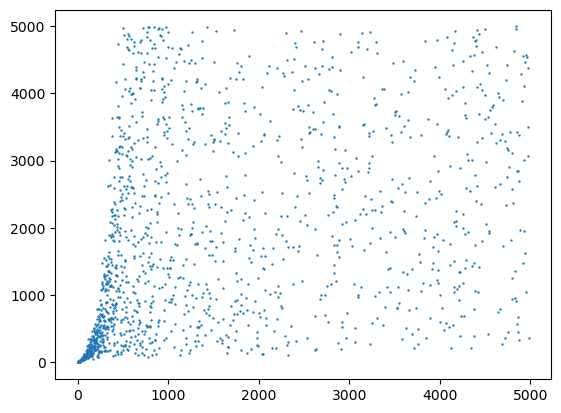

(0.0, 300.0)

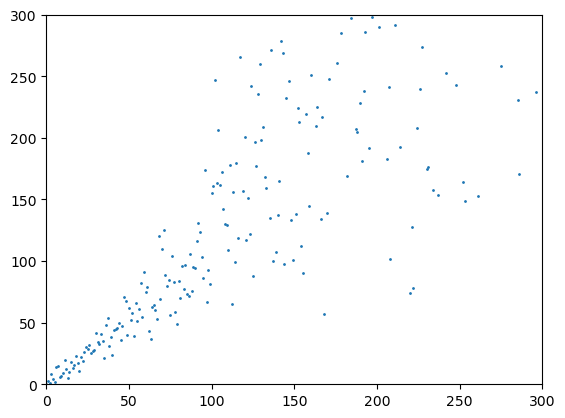

In [178]:
ct_1_rankings = res1.groupby("gene")["ranking"].max().sort_values().iloc[:5000].reset_index()
ct_1_rankings_mean = res1.groupby("gene")["ranking"].mean().sort_values().iloc[:5000].reset_index()

ct_1_rankings["inx_max"] = np.arange(0, ct_1_rankings.shape[0])
ct_1_rankings_mean["inx_mean"] = np.arange(0, ct_1_rankings_mean.shape[0])

grouped = pd.merge(ct_1_rankings, ct_1_rankings_mean, on="gene", how="inner")

plt.scatter(grouped["inx_max"], grouped["inx_mean"], s=0.5)
plt.show()

plt.scatter(grouped["inx_max"], grouped["inx_mean"], s=1)
plt.xlim(0, 300)
plt.ylim(0, 300)


# res1.loc[res1["gene"] == "FHOD3"]
# res1.loc[res1["gene"] == "BRINP3"]
# res1.loc[res1["gene"] == "SLC35F1"]
# # res1.loc[res1["gene"] == "MAN1C1"]
# res1.loc[res1["gene"] == "NTNG1"]


In [195]:
ex_markers_path = "/broad/macosko/jsilverm/pknn_cell_type_preds/HIMBA/markers_nonzero_group_label/SN_TH_Dopa/STR_VIP_GABA/markers.pkl"
obj = pickle.load(open(ex_markers_path, "rb"))


ex_markers_path = "/broad/macosko/jsilverm/pknn_cell_type_preds/HIMBA/markers_donor_nonzero/STRd_D1D2_Hybrid/STRd_D2_Matrix/markers.pkl"
obj = pickle.load(open(ex_markers_path, "rb"))

In [196]:
obj

{'STRd_D1D2_Hybrid': gene
 LUZP2         5
 ADARB2        5
 FOXP2         7
 KCNT2         8
 SEMA5B       10
            ... 
 COL10A1    6533
 SNAPC5     6549
 FAM43B     6550
 RPLP0      6551
 BACE2      6556
 Name: ranking, Length: 1000, dtype: int64,
 'STRd_D2_Matrix': gene
 MIR1302-2HG      0
 LINC01409        1
 FAM87B           2
 LINC01128        3
 LINC00115        4
               ... 
 DPYD           995
 DPYD-AS1       996
 DPYD-IT1       997
 DPYD-AS2       998
 MIR137HG       999
 Name: ranking, Length: 1000, dtype: int64}

# Create Models

In [342]:
def read_in_donor_chunked_objs(base_chunked_dir, cell_type, valid_markers_set=None, normalize=False):
    donor_dirs_present = os.listdir(base_chunked_dir)
    possible_cell_type_paths = [os.path.join(base_chunked_dir, donor_dir, f"{cell_type}.h5ad") for donor_dir in donor_dirs_present]
    cell_type_paths = [ct_path for ct_path in possible_cell_type_paths if os.path.exists(ct_path)]
    
    assert len(cell_type_paths) != 0, f"No paths found for {cell_type}"

    print("reading in objects")
    cell_type_objs = {}
    for cell_type_path in cell_type_paths:
        donor = cell_type_path.split("/")[-2]
        obj = ad.read_h5ad(cell_type_path)

        if valid_markers_set is not None:
            is_valid_gene = obj.var_names.isin(valid_markers_set)
            obj = obj[:,is_valid_gene]
        if normalize:
            obj.layers["counts"] = obj.X
            sc.pp.normalize_total(obj, target_sum=1e4)
            sc.pp.log1p(obj)
            obj.layers["data"] = obj.X
            
        cell_type_objs[donor] = obj
    return cell_type_objs



def create_donor_balanced_ref(cell_type_objs, target_size=300, seed=6):
    np.random.seed(seed)
    n_donors_total = len(cell_type_objs)

    size_per_donor = [(cell_type_objs[donor_id].shape[0], donor_id) for donor_id in cell_type_objs.keys()]

    size_per_donor = sorted(size_per_donor)
    n_sample_per_donor = {}
    n_remaining_to_sample = target_size
    
    for donor_inx, (n_per_donor, donor_id) in enumerate(size_per_donor):
        n_donors_remain = n_donors_total - donor_inx
        target_donor_size = int(np.ceil(n_remaining_to_sample / n_donors_remain))
        if n_per_donor <= target_donor_size:
            n_sample_per_donor[donor_id] = n_per_donor
            n_remaining_to_sample -= n_per_donor
        else:
            n_sample_per_donor[donor_id] = target_donor_size            
            n_remaining_to_sample -= target_donor_size

    sampled_adata_objs = {}
    for donor_id, n_to_sample in n_sample_per_donor.items():
        donor_adata = cell_type_objs[donor_id]
        sampled_indices = np.random.choice(donor_adata.shape[0], n_to_sample, replace=False)
        sampled_adata_objs[donor_id] = donor_adata[sampled_indices]

    combined_sampled_obj = ad.concat(sampled_adata_objs, axis=0)
    
    return combined_sampled_obj


def create_pred_model(cell_type_1, cell_type_2, cell_type_1_adata, cell_type_2_adata, markers, classifier_name="svm"):

    valid_classifiers = ["knn", "svm"]
    assert classifier_name in valid_classifiers, f"classifier_name must be in {valid_classifiers}"

    cell_type_1_mat_markers_only = cell_type_1_adata[:, markers].X.toarray()
    cell_type_2_mat_markers_only = cell_type_2_adata[:, markers].X.toarray()

    if classifier_name == "svm":
        classifier = SVC(
            kernel='rbf',  # Radial basis function kernel
            probability=True,  # Enable probability estimates
            random_state=42,
            class_weight='balanced'
        )
    elif classifier_name == "knn":
        classifier = KNeighborsClassifier(n_neighbors=12, metric="cosine", weights="distance")
        
    # Prepare training labels
    reference_labels = ([cell_type_1] * cell_type_1_mat_markers_only.shape[0] + 
                       [cell_type_2] * cell_type_2_mat_markers_only.shape[0])
    
    # Combine training data
    training_data = np.vstack([cell_type_1_mat_markers_only, cell_type_2_mat_markers_only])
    
    # Fit the classifier
    classifier.fit(training_data, reference_labels)
    
    res_obj = {"classifier": classifier, "cell_type1": cell_type_1, "cell_type2": cell_type_2,  "markers": markers}
    return res_obj

def predict_obj_from_classifier_obj(query_obj, query_cell_type, classifier_obj):
    """Assumes query_obj is normalized"""
    markers = classifier_obj["markers"]
    model = classifier_obj["classifier"]

    query_data_mat = query_obj[:,markers].X.toarray()

    class_labels = model.classes_
    if len(class_labels) != 2:
        raise ValueError("This function expects a binary classifier")
         
    # Get predictions and probabilities
    predictions = model.predict(query_data_mat)
    prediction_probs = model.predict_proba(query_data_mat)
    
    # Get probability for the positive class (confidence)
    
    
    # Calculate accuracy
    correct_mask = predictions == query_cell_type
    accuracy = np.mean(correct_mask)
    
    positive_class_idx = np.where(class_labels == query_cell_type)[0][0]
    negative_class_ixx = np.where(class_labels != query_cell_type)[0][0]
    mean_correct_minus_incorrect_p = np.mean(prediction_probs[:,positive_class_idx] -  prediction_probs[:,negative_class_ixx])

    res ={"query_cell_type":query_cell_type, "accuracy": accuracy, "conf_metric": mean_correct_minus_incorrect_p}

    
    return res


In [497]:

cell_type_1 = "STRd_D1_Striosome"
cell_type_2 = "STRd_D1_Matrix"
# markers_base = "/broad/macosko/jsilverm/pknn_cell_type_preds/HIMBA/markers_donor_nonzero"
markers_base = "/broad/macosko/jsilverm/pknn_cell_type_preds/HIMBA/markers_balanced_group_label"
cell_per_type = 300

chunked_reference_base = "/broad/macosko/jsilverm/pknn_cell_type_preds/HIMBA/donor_chunked_group_label"

marker_objs =  pf.read_in_sorted_subfolder_obj(cell_type_1, cell_type_2, markers_base, suffix="markers")




def create_paired_classifer_test_n_markers(cell_type_1, cell_type_2, chunked_reference_base, markers_base, base_classifier_path, cell_per_type=300, min_markers=5, max_markers=150, n_jump_markers=5, classifier_name="knn"):

    print(f"Read in {cell_type_1} objs")
    cell_type_1_objs = read_in_donor_chunked_objs(chunked_reference_base, cell_type_1, normalize=True)
    print(f"Read in {cell_type_2} objs")
    cell_type_2_objs = read_in_donor_chunked_objs(chunked_reference_base, cell_type_2, normalize=True)
    
    
    marker_objs =  pf.read_in_sorted_subfolder_obj(cell_type_1, cell_type_2, markers_base, suffix="markers")
    
    donors_ct_1 = list(cell_type_1_objs.keys())
    donors_ct_2 = list(cell_type_2_objs.keys())
    
    ct_1_heldout_dict = {"donor_witheld": [], "accuracy": [], "conf_metric": [], "n_genes_ct_1": [], "n_genes_ct_2": []}
    ct_2_heldout_dict = {"donor_witheld": [], "accuracy": [], "conf_metric": [], "n_genes_ct_1": [], "n_genes_ct_2": []}
    
    for n_genes_dir in np.arange(min_markers, max_markers, n_jump_markers):
        print(n_genes_dir)
        n_genes_ct1=n_genes_dir
        n_genes_ct2=n_genes_dir
    
        cell_type_1_markers = marker_objs[cell_type_1].sort_values(ascending=True).iloc[:n_genes_ct1]
        cell_type_2_markers = marker_objs[cell_type_2].sort_values(ascending=True).iloc[:n_genes_ct2]
        combined_markers_index = cell_type_1_markers.index.append(cell_type_2_markers.index)
        combined_markers = np.array(combined_markers_index)
        
        for inx, ct_1_donor in enumerate(donors_ct_1):
            query_obj = cell_type_1_objs.pop(ct_1_donor)
            ct_1_reference = create_donor_balanced_ref(cell_type_1_objs, cell_per_type)
            ct_2_reference = create_donor_balanced_ref(cell_type_2_objs, cell_per_type)
        
            current_classifier_obj = create_pred_model(cell_type_1, cell_type_2, ct_1_reference, ct_2_reference, combined_markers, classifier_name=classifier_name)
            predictions = predict_obj_from_classifier_obj(query_obj, cell_type_1, current_classifier_obj)
        
            ct_1_heldout_dict["donor_witheld"].append(ct_1_donor)
            ct_1_heldout_dict["accuracy"].append(predictions["accuracy"])
            ct_1_heldout_dict["conf_metric"].append(predictions["conf_metric"])
            ct_1_heldout_dict["n_genes_ct_1"].append(n_genes_ct1)
            ct_1_heldout_dict["n_genes_ct_2"].append(n_genes_ct2)
        
            cell_type_1_objs[ct_1_donor] = query_obj
        
        for inx, ct_2_donor in enumerate(donors_ct_2):
            query_obj = cell_type_2_objs.pop(ct_2_donor)
            ct_1_reference = create_donor_balanced_ref(cell_type_1_objs, cell_per_type)
            ct_2_reference = create_donor_balanced_ref(cell_type_2_objs, cell_per_type)
        
            current_classifier_obj = create_pred_model(cell_type_1, cell_type_2, ct_1_reference, ct_2_reference, combined_markers, classifier_name=classifier_name)
            predictions = predict_obj_from_classifier_obj(query_obj, cell_type_2, current_classifier_obj)
        
            ct_2_heldout_dict["donor_witheld"].append(ct_2_donor)
            ct_2_heldout_dict["accuracy"].append(predictions["accuracy"])
            ct_2_heldout_dict["conf_metric"].append(predictions["conf_metric"])
            ct_2_heldout_dict["n_genes_ct_1"].append(n_genes_ct1)
            ct_2_heldout_dict["n_genes_ct_2"].append(n_genes_ct2)
        
            cell_type_2_objs[ct_2_donor] = query_obj
    
    ct_1_heldout_df = pd.DataFrame(ct_1_heldout_dict)
    ct_2_heldout_df = pd.DataFrame(ct_2_heldout_dict)
    
    ct_1_preformance = ct_1_heldout_df.groupby("n_genes_ct_1")["conf_metric"].mean()
    ct_2_preformance = ct_2_heldout_df.groupby("n_genes_ct_1")["conf_metric"].mean()
    top_score_n_genes = (ct_1_preformance + ct_2_preformance).idxmax()
    
    acc_at_gene_selection_ct_1 = ct_1_heldout_df.loc[ct_1_heldout_df["n_genes_ct_1"] == top_score_n_genes, "accuracy"].mean()
    acc_at_gene_selection_ct_2 = ct_2_heldout_df.loc[ct_2_heldout_df["n_genes_ct_1"] == top_score_n_genes, "accuracy"].mean()
    
    
    # create final model based on results
    cell_type_1_markers = marker_objs[cell_type_1].sort_values(ascending=True).iloc[:top_score_n_genes]
    cell_type_2_markers = marker_objs[cell_type_2].sort_values(ascending=True).iloc[:top_score_n_genes]
    combined_markers_index = cell_type_1_markers.index.append(cell_type_2_markers.index)
    combined_markers = np.array(combined_markers_index)
    ct_1_reference = create_donor_balanced_ref(cell_type_1_objs, cell_per_type)
    ct_2_reference = create_donor_balanced_ref(cell_type_2_objs, cell_per_type)
    final_classifier_obj = create_pred_model(cell_type_1, cell_type_2, ct_1_reference, ct_2_reference, combined_markers, classifier_name=classifier_name)
    
    save_pairwise_model(cell_type_1, cell_type_2, base_classifier_path, final_classifier_obj, "classifier", order_alphabetically=True)

    meta_obj = {"features_selected": top_score_n_genes, "accuracy_ct_1": acc_at_gene_selection_ct_1, "accuracy_ct_2": acc_at_gene_selection_ct_2, 'n_gene_dist': top_score_n_genes}
    save_pairwise_model(cell_type_1, cell_type_2, base_classifier_path, meta_obj, "meta", order_alphabetically=True)



In [498]:

# # markers_base = "/broad/macosko/jsilverm/pknn_cell_type_preds/HIMBA/markers_donor_nonzero"
markers_base = "/broad/macosko/jsilverm/pknn_cell_type_preds/HIMBA/markers_balanced_group_label"
cell_per_type = 300
chunked_reference_base = "/broad/macosko/jsilverm/pknn_cell_type_preds/HIMBA/donor_chunked_group_label"
base_classifier_path = "/broad/macosko/jsilverm/pknn_cell_type_preds/HIMBA/classifiers_donor_nonzero"
classifer_name="knn"
create_paired_classifer_test_n_markers("STRd_D1_Striosome", "STRd_D1_Matrix", chunked_reference_base, markers_base, base_classifier_path, cell_per_type=300, min_markers=5, max_markers=150, n_jump_markers=5, classifer_name=classifer_name)



Read in STRd_D1_Striosome objs
reading in objects
Read in STRd_D1_Matrix objs
reading in objects
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145


In [499]:
meta_path = "/broad/macosko/jsilverm/pknn_cell_type_preds/HIMBA/classifiers_donor_nonzero/STRd_D1_Matrix/STRd_D1_Striosome/meta.pkl"
meta = pickle.load(open(meta_path, "rb"))

In [230]:
sampled_obj.obs["Donor_id"].value_counts()

Donor_id
1    75
3    75
4    75
5    75
Name: count, dtype: int64

In [203]:
markers

array(['MIR1302-2HG', 'LINC01409', 'FAM87B', ..., 'OR6Y1', 'SPINK7',
       'GCG'], dtype=object)